In [5]:
# Importando bibliotecas a serem utilizadas
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
import seaborn as sns
import matplotlib as plt
import stockstats
from ta.trend import ADXIndicator, MACD
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import catboost as cat
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
import seaborn as sns

In [6]:
# Funções de indicadores, div 0 e modelos

def boilinger(price, length = 30, num = 2):
    media = price.rolling(window = length, center = False).mean()
    desviop = price.rolling(window = length, center = False).std()
    upband = media + (desviop*num)
    downband = media - (desviop*num)
    return np.round(media, 3), np.round(upband, 3 ), np.round(downband, 3)

def rsi(values):
    up = values[values > 0].mean()
    down = -1*values[values < 0].mean()
    return 100*up/ (up + down)

def divisao_zero(n,d):
    try:
        return x/y
    except: ZeroDivisionError
    return 0

def lassoreg(Xtrain, ytrain, Xtest, ytest):
    '''função para aplicar a regressão lasso, num set de dados''' 
    lasso = LassoCV(cv= 5)
    lasso.fit(Xtrain, ytrain)
    vetor = pd.DataFrame({'y_pred_lasso':lasso.predict(Xtest)})
    vetor['y_real'] = np.array(ytest)

    MSE = mean_squared_error(vetor['y_real'], vetor['y_pred_lasso'])
    RMSE = math.sqrt(MSE)
    RMSE
    return RMSE, vetor


def lassomultireg(Xtrain, ytrain, Xtest, ytest):
    '''função para aplicar a regressão lasso, num set de dados''' 
    lasso = MultiTaskLassoCV(cv= 5)
    lasso.fit(Xtrain, ytrain)
    vetor = pd.DataFrame({'y_pred_lasso':lasso.predict(Xtest)})
    vetor['y_real'] = np.array(ytest)

    MSE = mean_squared_error(vetor['y_real'], vetor['y_pred_lasso'])
    RMSE = math.sqrt(MSE)
    RMSE
    return RMSE, vetor


def catreg(Xtrain, ytrain, Xtest, ytest):
    '''função para aplicar CatboostRegressor no set'''
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    cat_fit = cat.CatBoostRegressor(verbose = False)
    cat_fit.fit(scaler.transform(Xtrain), ytrain)    
    vetor = pd.DataFrame({'y_pred_cat':cat_fit.predict(Xtest)})
    vetor['y_real'] = np.array(ytest)
    y_pred = cat_fit.predict(scaler.transform(Xtest))
    
    MSE = mean_squared_error(vetor['y_real'], vetor['y_pred_cat'])
    RMSE = math.sqrt(MSE)
    RMSE
    return RMSE, vetor


def randomf(Xtrain, ytrain, Xtest, ytest):
    '''função para aplicar RandomForestRegressor no set'''
    scaler = StandardScaler()
    rfr_fit = RandomForestRegressor()
    scaler.fit(Xtrain)    
    rfr_fit.fit(Xtrain, ytrain)
    t_pred = rfr_fit.predict(scaler.transform(Xtest))

    
    vetor = pd.DataFrame({'y_pred_rfr':rfr_fit.predict(Xtest)})
    vetor['y_real'] = np.array(ytest)
    y_pred = rfr_fit.predict(scaler.transform(Xtest))
    
    MSE = mean_squared_error(vetor['y_real'], vetor['y_pred_rfr'])
    RMSE = math.sqrt(MSE)
    RMSE
    return RMSE, vetor

def keras_dense(Xtrain, ytrain, Xtest, ytest):
    input_dim = Xtrain.shape[1]
    output_dim = ytest.shape[1]
    model = Sequential()
    model.add(Dense(30, input_dim = input_dim, activation= "relu"))
    model.add(Dense(20, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(output_dim))
    model.compile(loss = 'mean_squared_error',
    optimizer= 'adam',
        metrics='accuracy'
    )
    h = model.fit(Xtrain, ytrain, epochs = 100, batch_size = 800)
    
    y_pred_prob = model.predict(Xtest)
    

    MSE = mean_squared_error(ytest , y_pred_prob)
    RMSE = math.sqrt(MSE)
    RMSE
    return RMSE, ytest, y_pred_prob

In [7]:
# Obtenção e tratamento dos dados 
dfs = os.listdir("C://Users/Lucas/Downloads/archive (1)")
dfs
dfs_final = []
for item in dfs:    
    a = pd.read_csv(f"C://Users/Lucas/Downloads/archive (1)/{item}")
    a['Date'] = pd.to_datetime(a['Date'])
    a['Date'] = a['Date'].dt.date
    a['Date'] = pd.to_datetime(a['Date'])
    a['Change'] = (a['Close'] - a['Close'].shift(1))/a['Close'].shift(1)
    a['RSI 15d'] = a['Change'].rolling(center = False, window = 15).apply(rsi)
    a['BoilingerMed'] , a['BoilingerUp'], a['BoilingerDn'] = boilinger(a['Close'], length = 20, num = 1)
    a['BoilingerMed'] = a['BoilingerMed']
    a['BoilingerUpdv'] = a['BoilingerUp'] - a['Close']
    a['BoilingerDndv'] = a['Close'] - a['BoilingerDn'] 
    a['Vol_Rel'] = divisao_zero(a['Volume'], a['Marketcap'])
    a['PVT'] = (((a['Close'] - a['Close'].shift(1))/a['Close'])*a['Volume']) 
    a['PVT'] = a['PVT'] + a['PVT'].shift(1)
    a['Adj Close'] = (a['Close'] + a['High'] + a['Low'])/3
    a['Adj Open'] = a['Open'] *a['Adj Close']/a['Close']
    a['Adj High'] = a['High'] *a['Adj Close']/a['Close']
    a['Adj Low'] = a['Low']* a['Adj Close']/a['Close']
    for dia in range(1, 16):
        a[f'dia_lag{dia}'] = a['Close'].shift(dia)
    adxI = ADXIndicator(a['Adj High'],a['Adj Low'],a['Adj Close'],14,False)
    a['pos_directional_indicator'] = adxI.adx_pos()
    a['neg_directional_indicator'] = adxI.adx_neg() 
    a['adx'] = adxI.adx()
    a['Trend'] = np.where(a['adx']>25, a['Adj Close'], 0 )
    a['Trend_Signal'] = np.where(a.adx>25,1,0)
    a['Direction'] = np.where(a['pos_directional_indicator'] > a['neg_directional_indicator'],1,-1) * a['Trend_Signal']
    a['Close_+1'] = a['Close'].shift(-1)
    a['Close_+3'] = a['Close'].shift(-3)
    a['Close_+5'] = a['Close'].shift(-5)
    a = a.drop(['BoilingerMed', 'BoilingerUp', 'BoilingerDn', 'Adj Open', 'Adj High', 
            'Adj Low', 'pos_directional_indicator', 
            'neg_directional_indicator', 'Trend', 
            'Trend_Signal', 'SNo', 'Name', 'High', 
            'Low', 'Open', 'Volume', 'Marketcap'], axis= 1)
    a = a.dropna()

    dfs_final.append(a)

dado = pd.concat(dfs_final, axis= 0)

c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Lucas\anaconda3\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\Lucas\a

In [10]:
# Criação das três tabelas a serem utilizadas Indicadores, Preço anterior e outras moedas
#Outras Moedas e Divisão test e train


X_outras = dado.pivot_table(values = 'Close', index = 'Date', columns = 'Symbol')
X_outras = X_outras.drop(['AAVE', 'DOT', 'SOL', 'UNI'], axis= 1)
X_outras = X_outras.dropna()

y_outras = dado.pivot_table(columns = 'Symbol', values = 'Close_+1', index = 'Date')
y_outras = y_outras.drop(['AAVE', 'DOT', 'SOL', 'UNI'], axis= 1)
y_outras = y_outras.dropna()
y_outras = y_outras.drop(['ADA', 'CRO', 'DOGE', 'EOS','XEM', 
'XLM', 'XMR', 'USDT', 'USDC', 'WBTC','TRX', 'XMR', 'XRP', 'MIOTA', 'ATOM', 'BTC', 'ETH', 'LINK', 'LTC'], axis= 1)



Xtest_outras = X_outras.iloc[-3:]

Xtrain_outras = X_outras.iloc[0:-3]
ytest_outras = y_outras.iloc[-3:]
ytrain_outras = y_outras.iloc[0:-3]

outras = [Xtrain_outras, ytrain_outras, Xtest_outras, ytest_outras]


In [11]:
RMSE_outras_lasso, prev_outras_lasso = lassoreg(Xtrain_outras, ytrain_outras, Xtest_outras, ytest_outras)
RMSE_outras_cat, prev_outras_cat = catreg(Xtrain_outras, ytrain_outras, Xtest_outras, ytest_outras)
RMSE_outras_rfr, prev_outras_rfr = randomf(Xtrain_outras, ytrain_outras, Xtest_outras, ytest_outras)
RMSE_outras_dense, valor_real, prev_outras_dense = keras_dense(Xtrain_outras, ytrain_outras, Xtest_outras, ytest_outras)



c:\Users\Lucas\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_1172\118385992.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_fit.fit(Xtrain, ytrain)
c:\Users\Lucas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Lucas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Epoch 1/100
2/2 [==============================] - 1s 4ms/step - loss: 62074128.0000 - accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 51156032.0000 - accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 41979980.0000 - accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 9ms/step - loss: 36889208.0000 - accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 33538706.0000 - accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 29972540.0000 - accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 26544358.0000 - accuracy: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 23291818.0000 - accuracy: 0.0000e+00
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 20378032.0000 - accuracy: 0.0000e+00
Epoch 10/100
2/2 [==========

In [23]:
lista_df_y = []

listaRMSE = [RMSE_outras_lasso, RMSE_outras_cat, RMSE_outras_rfr, RMSE_outras_dense ]
listays = [prev_outras_lasso, prev_outras_cat, prev_outras_rfr, prev_outras_dense ]

for item in listays:
    a = pd.DataFrame(item)
    lista_df_y.append(a)
result_y = pd.concat(lista_df_y)
result_y = result_y.apply(lambda x: pd.Series(x.dropna().values))
result_y = result_y.head(3)




<AxesSubplot:>

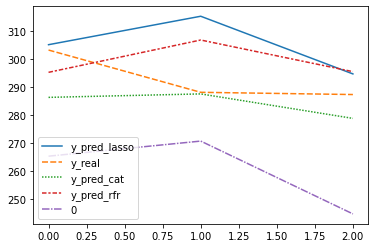

In [24]:
sns.lineplot(data= result_y)

In [26]:
rmse = pd.DataFrame({'RMSE_outras_lasso': RMSE_outras_lasso,  'RMSE_outras_rfr': RMSE_outras_rfr, 
                    'RMSE_outras_cat': RMSE_outras_cat,'RMSE_outras_dense ': RMSE_outras_dense })
rmse

ValueError: If using all scalar values, you must pass an index